### 加载数据

In [1]:
import os

dir = "D:\\01\\0Food challenge\\Tofu and potatoes"
train_dir = "D:\\01\\0Food challenge\\Tofu and potatoes\\train"
test_dir = "D:\\01\\0Food challenge\\Tofu and potatoes\\test"

print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))

7502
1047


In [2]:
import pandas as pd

y_train_df = pd.read_csv(os.path.join(dir,"train.csv"),names=["id","label"])
y_train_df.head()

,id,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


1    4533
0    2969
Name: label, dtype: int64

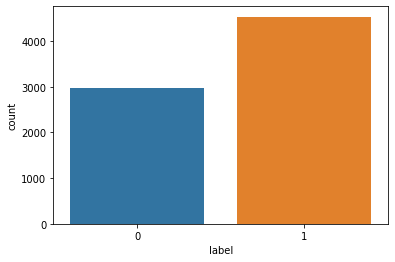

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_train = y_train_df["label"]

g = sns.countplot(Y_train)
Y_train.value_counts()

In [4]:
from sklearn.utils import class_weight
import numpy as np

classweight = class_weight.compute_class_weight("balanced",np.unique(Y_train),Y_train)
print(classweight)
# class_weight = {[1.26338835 0.82748732]}

[1.26338835 0.82748732]


In [5]:
# 定义读取图片函数
import cv2
import numpy as np

def get_img(file_path,img_rows,img_cols):
  
    img = cv2.imread(file_path)
    img = cv2.resize(img,(img_rows,img_cols))
    if img.shape[2] == 1:
        img = np.dstack([img,img,img])
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [6]:
x_train_img_path = y_train_df["id"]

# 加载训练集
X_train = []
for img_name in x_train_img_path:
    img_name = str(img_name) + ".jpg"
    img = get_img(os.path.join(train_dir,img_name),224,224)
    X_train.append(img)

X_train = np.array(X_train,np.float32)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\core\src\alloc.cpp:72: error: (-4:Insufficient memory) Failed to allocate 1440000 bytes in function 'cv::OutOfMemoryError'


In [ ]:
print(X_train.shape)
print(Y_train.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_train[0]/255)
print(Y_train[0])

In [ ]:
# 对标签数据进行one-hot编码
n_classes = len(np.unique(Y_train))

from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train,n_classes)
print("Shape after one-hot encoding:",Y_train.shape)

In [ ]:
# 划分数据集
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(X_train,Y_train,test_size=0.3,random_state=2019)



print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)



In [ ]:
# 导入开发需要的库
from keras import optimizers, Input
from keras.applications import  imagenet_utils

from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications import *

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *

In [ ]:
# 绘制训练过程中的 loss 和 acc 变化曲线
import matplotlib.pyplot as plt
%matplotlib inline

def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history["acc"])
    plt.plot(history_fit.history["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history["loss"])
    plt.plot(history_fit.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    
    plt.show()

In [ ]:
# 模型编译
import keras.backend as K

# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [ ]:
# fine-tune 模型
def fine_tune_model(model, optimizer, batch_size, epochs, freeze_num):
    '''
    discription: 对指定预训练模型进行fine-tune，并保存为.hdf5格式
    
    MODEL：传入的模型，VGG16， ResNet50, ...

    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数
    freeze_num: first part冻结卷积层的数量
    '''

    # datagen = ImageDataGenerator(
    #     rescale=1.255,
    #     # shear_range=0.2,
    #     # zoom_range=0.2,
    #     # horizontal_flip=True,
    #     # vertical_flip=True,
    #     # fill_mode="nearest"
    #   )
    
    # datagen.fit(X_train)
    
    
#     # first: 仅训练全连接层（权重随机初始化的）
#     # 冻结所有卷积层
    
#     for layer in model.layers[:freeze_num]:
#         layer.trainable = False
    
#     model.compile(optimizer=optimizer, 
#                   loss="categorical_crossentropy",
#                   metrics=["accuracy"])

#     # model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
#     #                     steps_per_epoch=len(x_train)/32,
#     #                     epochs=3,
#     #                     shuffle=True,
#     #                     verbose=1,
#     #                     datagen.flow(x_valid, y_valid))
#     model.fit(X_train,
#          Y_train,
#          batch_size=batch_size,
#          epochs=3,
#          shuffle=True,
#          verbose=1,
#          validation_split=0.3
#         )
#     print('Finish step_1')
    
    
    # second: fine-tune all layers
    for layer in model.layers[:]:
        layer.trainable = True
    
    rc = ReduceLROnPlateau(monitor="val_loss",
                factor=0.2,
                patience=3,
                verbose=1,
                mode='min')

    model_name = model.name  + ".hdf5"
    mc = ModelCheckpoint(model_name, 
               monitor="val_loss", 
               save_best_only=True,
               verbose=1,
               mode='min')
    el = EarlyStopping(monitor="val_loss",
              min_delta=0,
              patience=5,
              verbose=1,
              restore_best_weights=True)
    
    model.compile(optimizer=optimizer, 
           loss='categorical_crossentropy', 
           metrics=["accuracy"])

    # history_fit = model.fit_generator(datagen.flow(x_train,y_train,batch_size=32),
    #                                  steps_per_epoch=len(x_train)/32,
    #                                  epochs=epochs,
    #                                  shuffle=True,
    #                                  verbose=1,
    #                                  callbacks=[mc,rc,el],
    #                                  datagen.flow(x_valid, y_valid))
    history_fit = model.fit(X_train,
                 Y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 shuffle=True,
                 verbose=1,
                 validation_split=0.3,
                 callbacks=[mc,rc,el],
                 class_weight={0:1.26338835,1:0.82748732})
    
    print('Finish fine-tune')
    return history_fit

### VGG16模型

In [ ]:
# 定义一个VGG16的模型
def vgg16_model(img_rows,img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    base_model = VGG16(input_tensor=x,weights="imagenet",include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024,activation="relu",name="fc1")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes,activation="softmax",name="predictions")(x)  
    vgg16_model = Model(inputs=base_model.input,outputs=predictions,name="vgg16")
    
    return vgg16_model

In [ ]:
# 创建VGG16模型
img_rows, img_cols = 224, 224
vgg16_model = vgg16_model(img_rows,img_cols)

In [28]:
optimizer = optimizers.Adam(lr=0.0001)
batch_size = 32
epochs = 30
freeze_num = 21


%time vgg16_history = fine_tune_model(vgg16_model,optimizer,batch_size,epochs,freeze_num)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5251 samples, validate on 2251 samples
Epoch 1/30
5251/5251 [==============================] - 112s 21ms/step - loss: 1.5082 - acc: 0.7513 - val_loss: 0.4705 - val_acc: 0.8801

Epoch 00001: val_loss improved from inf to 0.47049, saving model to vgg16.hdf5
Epoch 2/30
5251/5251 [==============================] - 101s 19ms/step - loss: 0.7746 - acc: 0.8497 - val_loss: 0.3659 - val_acc: 0.9054

Epoch 00002: val_loss improved from 0.47049 to 0.36587, saving model to vgg16.hdf5
Epoch 3/30
5251/5251 [==============================] - 103s 20ms/step - loss: 0.5492 - acc: 0.8787 - val_loss: 0.2995 - val_acc: 0.9156

Epoch 00003: val_loss improved from 0.36587 to 0.29953, saving model to vgg16.hdf5
Epoch 4/30
5251/5251 [==============================] - 100s 19ms/step - loss: 0.4262 - acc: 0.8960 - val_loss: 0.2683 - val_acc: 0.9174

Epoch 00004: val_loss improved from 0.29953 to 0.26831, savin

### EfficentNet模型

In [14]:
# 导入Efficient模块
from efficientnet.keras import EfficientNetB3
import keras.backend as K

In [15]:
# 定义一个EfficientNet模型
def efficient_model(img_rows,img_cols):
    K.clear_session()
    x = Input(shape=(img_rows,img_cols,3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = EfficientNetB3(input_tensor=x,weights="imagenet",include_top=False,pooling="avg")
    x = base_model.output
    x = Dense(32,activation="relu",name="fc1")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes,activation="softmax",name="predictions")(x)
    eB_model = Model(inputs=base_model.input,outputs=predictions,name="eB3")
    
    return eB_model

In [16]:
# 创建Efficient模型
img_rows,img_cols=224,224
eB_model = efficient_model(img_rows,img_cols)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
optimizer = optimizers.Adam(lr=0.0001)
batch_size = 2
epochs = 30
freeze_num = 379
eB_model_history  = fine_tune_model(eB_model,optimizer,batch_size,epochs,freeze_num)

Train on 5251 samples, validate on 2251 samples
Epoch 1/30
5251/5251 [==============================] - 678s 129ms/step - loss: 0.1007 - acc: 0.9665 - val_loss: 0.3112 - val_acc: 0.9271

Epoch 00001: val_loss improved from inf to 0.31122, saving model to eB3.hdf5
Epoch 2/30
5251/5251 [==============================] - 652s 124ms/step - loss: 0.0892 - acc: 0.9686 - val_loss: 0.3130 - val_acc: 0.9249

Epoch 00002: val_loss did not improve from 0.31122
Epoch 3/30
5251/5251 [==============================] - 647s 123ms/step - loss: 0.0679 - acc: 0.9773 - val_loss: 0.2228 - val_acc: 0.9471

Epoch 00003: val_loss improved from 0.31122 to 0.22276, saving model to eB3.hdf5
Epoch 4/30
5251/5251 [==============================] - 648s 123ms/step - loss: 0.0692 - acc: 0.9766 - val_loss: 0.4716 - val_acc: 0.8281

Epoch 00004: val_loss did not improve from 0.22276
Epoch 5/30
5251/5251 [==============================] - 645s 123ms/step - loss: 0.0617 - acc: 0.9796 - val_loss: 0.3340 - val_acc: 0.914

### 预测

In [18]:
import re


x_test_img_path = os.listdir(test_dir)
x_test_img_path = sorted(x_test_img_path,key = lambda i:int(re.match(r"(\d+)",i).group()))

x_test = []
for img_name in x_test_img_path:
    img = get_img(os.path.join(test_dir,img_name),224,224)
    x_test.append(img)

x_test = np.array(x_test,np.float32)

In [19]:
print(x_test.shape)

(1047, 224, 224, 3)


In [20]:
eB_model.load_weights("./eB3.hdf5")

In [21]:
y_pred = eB_model.predict(x_test)

In [22]:
y_pred[0]

array([0.99832207, 0.00167793], dtype=float32)

In [23]:
predict = np.argmax(y_pred,axis=1)

In [24]:
predict

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [25]:
len = predict.shape[0]

In [26]:
id = np.arange(len)

In [27]:
df = pd.DataFrame({"id":id,"predict":predict})

In [28]:
df.to_csv("submit_efficient.csv",index=None,header=None)